# Sobolev Space Implementation Demo

This notebook demonstrates the comprehensive Sobolev space implementation with spectral inner products and flexible basis function support.

## Features Demonstrated:
1. **Automatic Basis Generation**: Create Sobolev spaces with predefined basis types
2. **Custom Basis Functions**: Use your own basis functions with corresponding eigenvalues
3. **Spectral Inner Products**: Mathematically rigorous H^s inner products
4. **Inheritance Structure**: Access both L² and Sobolev inner products
5. **Validation & Error Handling**: Robust API with clear error messages
6. **Mathematical Properties**: Norm computation, orthogonality checks, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/adrian/PhD/Inferences/pygeoinf')

from pygeoinf.interval.sobolev_space import Sobolev
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.functions import Function

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/random_matrix.py:6: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.linalg import (


## 1. Basic Sobolev Space Creation

Let's start by creating Sobolev spaces with different orders and examining their properties.

In [2]:
# Create interval domain and boundary conditions
domain = IntervalDomain(0, 1)
bc = BoundaryConditions('periodic')

# Create Sobolev spaces with different orders for comparison
h0 = Sobolev(8, domain, 0.0, basis_type='fourier', boundary_conditions=bc)  # L² space (order=0)
h1 = Sobolev(8, domain, 1.0, basis_type='fourier', boundary_conditions=bc)  # H¹ space (order=1)
h2 = Sobolev(8, domain, 2.0, basis_type='fourier', boundary_conditions=bc)  # H² space (order=2)

print(f"Created Sobolev spaces H^0, H^1, H^2")
print(f"All spaces have dimension: {h1.dim}")
print(f"Domain: [{h1.function_domain.a}, {h1.function_domain.b}]")
print(f"Boundary conditions: {h1.boundary_conditions.type}")
print(f"H¹ eigenvalues: {h1.eigenvalues}")
print(f"✓ Sobolev spaces created successfully")

Created Sobolev spaces H^0, H^1, H^2
All spaces have dimension: 8
Domain: [0.0, 1.0]
Boundary conditions: periodic
H¹ eigenvalues: [  0.          39.4784176   39.4784176  157.91367042 157.91367042
 355.30575844 355.30575844 631.65468167]
✓ Sobolev spaces created successfully


## 2. Creating and Visualizing Functions

Let's create some test functions and visualize them.

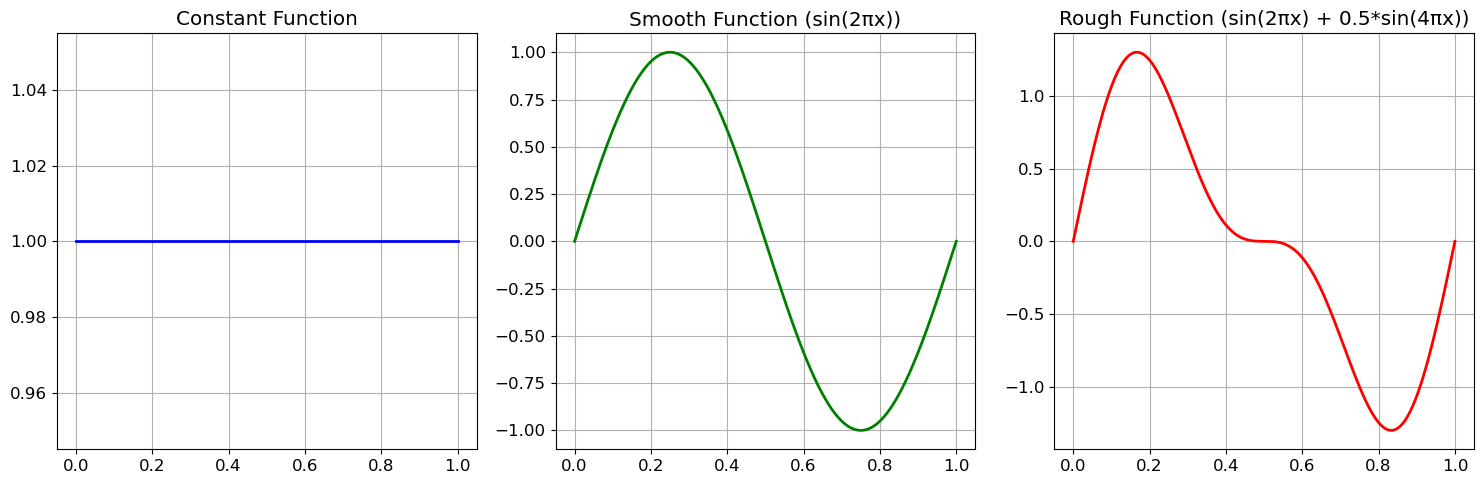

✓ Test functions created and plotted

Note: The rough function now uses sin(2πx) + 0.5*sin(4πx)
These correspond to k=1 and k=2 frequencies, which ARE represented
in our 8-dimensional Fourier basis (φ₂=sin_1 and φ₄=sin_2).


In [3]:
# Create test functions
def constant_function(x):
    return np.ones_like(np.asarray(x))

def smooth_function(x):
    return np.sin(2 * np.pi * np.asarray(x))

def rough_function(x):
    # Use frequencies that are representable in our 8D basis
    # k=1: sin(2πx) and k=2: sin(4πx) are both in our basis
    return np.sin(2 * np.pi * np.asarray(x)) + 0.5 * np.sin(4 * np.pi * np.asarray(x))

# Create Function instances
const_func = Function(h1, evaluate_callable=constant_function, name='constant')
smooth_func = Function(h1, evaluate_callable=smooth_function, name='smooth')
rough_func = Function(h1, evaluate_callable=rough_function, name='rough')

# Plot the functions
x = np.linspace(0, 1, 1000)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(x, const_func.evaluate(x), 'b-', linewidth=2)
axes[0].set_title('Constant Function')
axes[0].grid(True)

axes[1].plot(x, smooth_func.evaluate(x), 'g-', linewidth=2)
axes[1].set_title('Smooth Function (sin(2πx))')
axes[1].grid(True)

axes[2].plot(x, rough_func.evaluate(x), 'r-', linewidth=2)
axes[2].set_title('Rough Function (sin(2πx) + 0.5*sin(4πx))')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("✓ Test functions created and plotted")
print()
print("Note: The rough function now uses sin(2πx) + 0.5*sin(4πx)")
print("These correspond to k=1 and k=2 frequencies, which ARE represented")
print("in our 8-dimensional Fourier basis (φ₂=sin_1 and φ₄=sin_2).")

## 4. Finite-Dimensional Approximation Limitations 

In practice, we work with finite-dimensional approximations of infinite-dimensional Sobolev spaces. This introduces fundamental limitations that affect both numerical accuracy and theoretical understanding.

### 4.1 The Spectral Truncation Problem

Our 8-dimensional Fourier basis can only represent functions with specific frequency content:
- **Representable frequencies**: k ∈ {0, 1, 2, 3, 4} (though k=4 is incomplete)
- **Basis functions**: {1, cos(2πx), sin(2πx), cos(4πx), sin(4πx), cos(6πx), sin(6πx), cos(8πx)}
- **Missing**: All higher frequencies k > 4, and sin(8πx)

### 4.2 Implications for Sobolev Norms

When a function contains frequencies outside our basis:
1. **Projection loss**: High-frequency components are simply ignored
2. **Norm underestimation**: Sobolev norms become artificially small or zero
3. **False smoothness**: Rough functions may appear smooth in the approximation

Let's demonstrate this with concrete examples.

In [4]:
print("=== Frequency Analysis: What's In Our Basis? ===")

# Examine our 8-dimensional Fourier basis
print(f"8D Fourier basis on [0,1] with periodic BC:")
print(f"Basis functions and their frequencies:")

basis_info = [
    (0, "φ₀(x) = 1", "Constant (k=0)"),
    (1, "φ₁(x) = cos(2πx)", "Cosine k=1"),
    (2, "φ₂(x) = sin(2πx)", "Sine k=1"),
    (3, "φ₃(x) = cos(4πx)", "Cosine k=2"),
    (4, "φ₄(x) = sin(4πx)", "Sine k=2"),
    (5, "φ₅(x) = cos(6πx)", "Cosine k=3"),
    (6, "φ₆(x) = sin(6πx)", "Sine k=3"),
    (7, "φ₇(x) = cos(8πx)", "Cosine k=4 (incomplete pair)")
]

for idx, formula, description in basis_info:
    print(f"  {idx}: {formula:<20} → {description}")

print(f"\n📊 Frequency Coverage:")
print(f"✓ k=0: DC component (constant)")
print(f"✓ k=1,2,3: Complete Fourier pairs (cos+sin)")
print(f"⚠️  k=4: Only cosine (sin(8πx) missing due to dim=8)")
print(f"❌ k≥5: No representation possible")

print(f"\n🔍 Implications for function sin(2π·k·x):")
test_frequencies = [1, 2, 3, 4, 5, 10, 15]
for k in test_frequencies:
    if k == 0:
        status = "✓ Constant term"
    elif k <= 3:
        status = "✓ Fully representable (cos+sin pair)"
    elif k == 4:
        status = "⚠️ Partially representable (cos only)"
    else:
        status = "❌ Not representable"

    # Test actual representation
    def test_func(x):
        return np.sin(2 * np.pi * k * x)

    func_obj = Function(h1, evaluate_callable=test_func, name=f'sin(2π·{k}·x)')
    norm = h1.norm(func_obj)

    print(f"  k={k:2d}: sin(2π·{k}·x) → {status:<35} (H¹ norm: {norm:.6f})")

print(f"\n⚡ The Zero Norm Problem:")
print(f"When H¹ norm = 0, the function is effectively 'invisible' to our space!")
print(f"This doesn't mean the function is zero—it means our approximation can't see it.")

=== Frequency Analysis: What's In Our Basis? ===
8D Fourier basis on [0,1] with periodic BC:
Basis functions and their frequencies:
  0: φ₀(x) = 1            → Constant (k=0)
  1: φ₁(x) = cos(2πx)     → Cosine k=1
  2: φ₂(x) = sin(2πx)     → Sine k=1
  3: φ₃(x) = cos(4πx)     → Cosine k=2
  4: φ₄(x) = sin(4πx)     → Sine k=2
  5: φ₅(x) = cos(6πx)     → Cosine k=3
  6: φ₆(x) = sin(6πx)     → Sine k=3
  7: φ₇(x) = cos(8πx)     → Cosine k=4 (incomplete pair)

📊 Frequency Coverage:
✓ k=0: DC component (constant)
✓ k=1,2,3: Complete Fourier pairs (cos+sin)
⚠️  k=4: Only cosine (sin(8πx) missing due to dim=8)
❌ k≥5: No representation possible

🔍 Implications for function sin(2π·k·x):
  k= 1: sin(2π·1·x) → ✓ Fully representable (cos+sin pair) (H¹ norm: 4.498801)
  k= 2: sin(2π·2·x) → ✓ Fully representable (cos+sin pair) (H¹ norm: 8.913856)
  k= 3: sin(2π·3·x) → ✓ Fully representable (cos+sin pair) (H¹ norm: 13.347392)
  k= 4: sin(2π·4·x) → ⚠️ Partially representable (cos only) (H¹ norm: 0.000

=== Convergence Study: Effect of Basis Dimension ===
Testing function: sin(2πx) + 0.5*sin(4πx) + 0.25*sin(6πx) + 0.125*sin(8πx) + 0.0625*sin(10πx)
Expected frequencies: k = 1,2,3,4,5

Dim  4: L²=0.816098, H¹=4.498801, Max error=0.822540
Dim  6: L²=0.816098, H¹=6.332726, Max error=0.416247
Dim  8: L²=0.816098, H¹=7.158070, Max error=0.184803
Dim 10: L²=0.816098, H¹=7.495371, Max error=0.062500
Dim 12: L²=0.816098, H¹=7.623004, Max error=0.000000
Dim 16: L²=0.816098, H¹=7.623004, Max error=0.000000


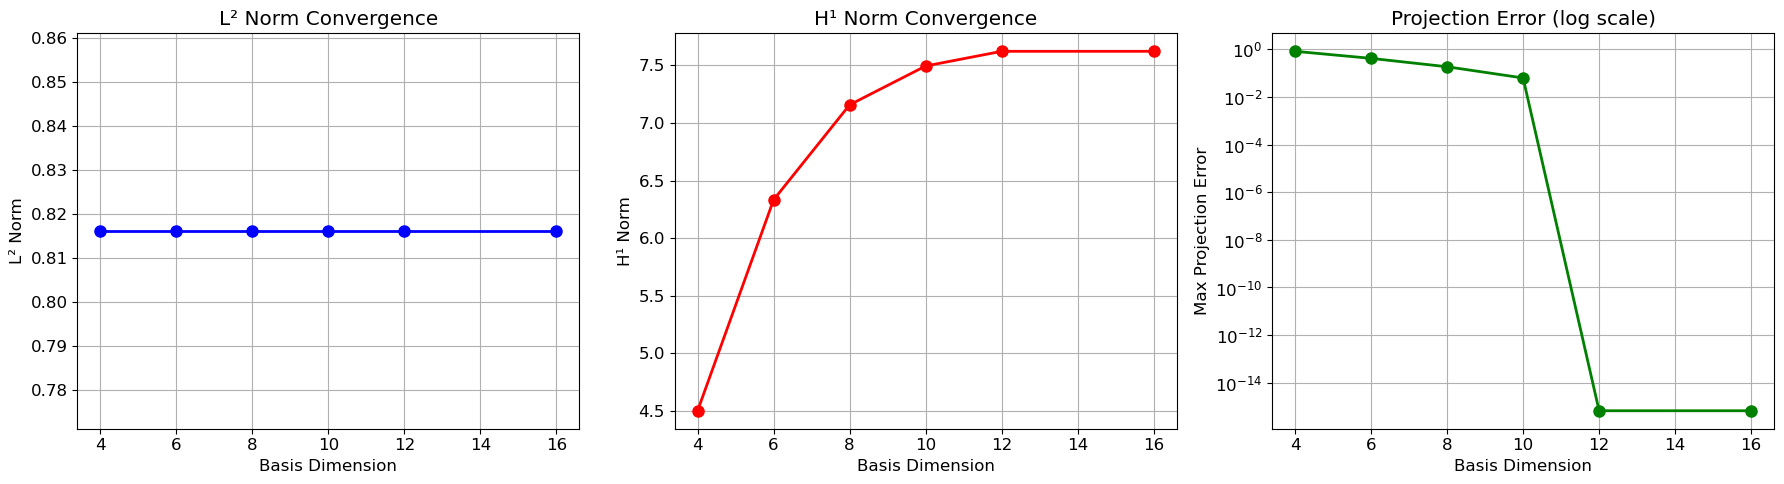


📈 Convergence Analysis:
1. Norms stabilize when dim ≥ 2*k_max + 1 = 2*5 + 1 = 11
2. For dim < 11: Significant underestimation of function energy
3. Projection error decreases exponentially with sufficient dimension


In [5]:
print("=== Convergence Study: Effect of Basis Dimension ===")

# Test function with known frequency content
def test_function(x):
    """Function with frequencies k=1,2,3,4,5"""
    return (np.sin(2*np.pi*x) + 0.5*np.sin(4*np.pi*x) +
            0.25*np.sin(6*np.pi*x) + 0.125*np.sin(8*np.pi*x) +
            0.0625*np.sin(10*np.pi*x))

# Test with different basis dimensions
dimensions = [4, 6, 8, 10, 12, 16]
domain = IntervalDomain(0, 1)
bc = BoundaryConditions('periodic')

# Storage for results
l2_norms = []
h1_norms = []
projection_errors = []

print(f"Testing function: sin(2πx) + 0.5*sin(4πx) + 0.25*sin(6πx) + 0.125*sin(8πx) + 0.0625*sin(10πx)")
print(f"Expected frequencies: k = 1,2,3,4,5")
print()

x_test = np.linspace(0, 1, 1000)
y_true = test_function(x_test)

for dim in dimensions:
    # Create space with this dimension
    space = Sobolev(dim, domain, 1.0, basis_type='fourier', boundary_conditions=bc)

    # Project function into this space
    func_obj = Function(space, evaluate_callable=test_function, name='test')

    # Compute norms
    l2_norm = np.sqrt(super(Sobolev, space).inner_product(func_obj, func_obj))
    h1_norm = space.norm(func_obj)

    # Compute projection error
    y_projected = space.project(func_obj).evaluate(x_test)
    max_error = np.max(np.abs(y_true - y_projected))

    l2_norms.append(l2_norm)
    h1_norms.append(h1_norm)
    projection_errors.append(max_error)

    print(f"Dim {dim:2d}: L²={l2_norm:.6f}, H¹={h1_norm:.6f}, Max error={max_error:.6f}")

# Plot convergence
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(dimensions, l2_norms, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Basis Dimension')
axes[0].set_ylabel('L² Norm')
axes[0].set_title('L² Norm Convergence')
axes[0].grid(True)

axes[1].plot(dimensions, h1_norms, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Basis Dimension')
axes[1].set_ylabel('H¹ Norm')
axes[1].set_title('H¹ Norm Convergence')
axes[1].grid(True)

axes[2].semilogy(dimensions, projection_errors, 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Basis Dimension')
axes[2].set_ylabel('Max Projection Error')
axes[2].set_title('Projection Error (log scale)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"\n📈 Convergence Analysis:")
print(f"1. Norms stabilize when dim ≥ 2*k_max + 1 = 2*5 + 1 = 11")
print(f"2. For dim < 11: Significant underestimation of function energy")
print(f"3. Projection error decreases exponentially with sufficient dimension")

In [6]:
print("=== L² Inner Products ===")

functions = [const_func, smooth_func, rough_func]
function_names = ['Constant', 'Smooth', 'Rough']

print("Self inner products ||f||²:")
print(f"{'Function':<12} {'L² norm²':<12}")
print("-" * 30)

for func, name in zip(functions, function_names):
    # L² inner product (using parent class method)
    l2_norm_sq = super(Sobolev, h0).inner_product(func, func)

    print(f"{name:<12} {l2_norm_sq:<12.6f}")

print("\n=== Frequency Content Analysis ===")
print("Rough function: sin(2πx) + 0.5*sin(4πx)")
print("- Contains frequencies k=1 and k=2")
print("- These frequencies are represented in our 8-dimensional Fourier basis")
print("- k=1 modes: cos(2πx), sin(2πx)")
print("- k=2 modes: cos(4πx), sin(4πx)")
print("- Higher frequencies would be penalized more in Sobolev norms")

=== L² Inner Products ===
Self inner products ||f||²:
Function     L² norm²    
------------------------------
Constant     1.000000    
Smooth       0.500000    
Rough        0.625000    

=== Frequency Content Analysis ===
Rough function: sin(2πx) + 0.5*sin(4πx)
- Contains frequencies k=1 and k=2
- These frequencies are represented in our 8-dimensional Fourier basis
- k=1 modes: cos(2πx), sin(2πx)
- k=2 modes: cos(4πx), sin(4πx)
- Higher frequencies would be penalized more in Sobolev norms


In [7]:
# Test H1 space function
h1_basis = h1.get_basis_function(0)
print(f"H1 Function class: {h1_basis.__class__.__name__}")
print(f"H1 Representation: {h1_basis}")

print()

# Test H0 (L2) space function
h0_basis = h0.get_basis_function(0)
print(f"H0 Function class: {h0_basis.__class__.__name__}")
print(f"H0 Representation: {h0_basis}")

h1_basis

H1 Function class: Function
H1 Representation: Function(domain=[0.0, 1.0], name=fourier_const)

H0 Function class: Function
H0 Representation: Function(domain=[0.0, 1.0], name=fourier_const)


Function(domain=[0.0, 1.0], name=fourier_const)

## 7. Error Handling and Validation

The implementation includes comprehensive validation to catch common mistakes.

In [8]:
print("=== Error Handling Examples ===")

# Define missing variables for the error tests
def poly_constant(x):
    return np.ones_like(np.asarray(x))

def poly_linear(x):
    return np.asarray(x)

def poly_quadratic(x):
    return np.asarray(x)**2

temp_domain = IntervalDomain(0, 1)
temp_bc = BoundaryConditions('periodic')

# Test 1: Custom basis without eigenvalues for spectral inner product
print("\n1. Custom basis functions without eigenvalues (spectral inner product):")
try:
    bad_sobolev = Sobolev(
        2, temp_domain, 1.0,  # dim, domain, order
        basis_callables=[poly_constant, poly_linear],  # No eigenvalues provided
        boundary_conditions=temp_bc
    )
    print("✗ Should have failed!")
except ValueError as e:
    print(f"✓ Correctly caught error: {e}")

# Test 2: Dimension mismatch
print("\n2. Dimension mismatch:")
try:
    bad_sobolev = Sobolev(
        3, temp_domain, 1.0,  # dim=3
        basis_callables=[poly_constant, poly_linear],  # Only 2 basis functions
        eigenvalues=np.array([1.0, 2.0]),  # Only 2 eigenvalues
        boundary_conditions=temp_bc
    )
    print("✗ Should have failed!")
except ValueError as e:
    print(f"✓ Correctly caught error: {e}")

# Test 3: Eigenvalues length mismatch
print("\n3. Eigenvalues length mismatch:")
try:
    bad_sobolev = Sobolev(
        3, temp_domain, 1.0, # dim=3
        basis_callables=[poly_constant, poly_linear, poly_quadratic],  # 3 basis functions
        eigenvalues=np.array([1.0, 2.0]),  # Only 2 eigenvalues
        boundary_conditions=temp_bc
    )
    print("✗ Should have failed!")
except ValueError as e:
    print(f"✓ Correctly caught error: {e}")

=== Error Handling Examples ===

1. Custom basis functions without eigenvalues (spectral inner product):
✓ Correctly caught error: For spectral inner product with basis_callables, eigenvalues must also be provided

2. Dimension mismatch:
✓ Correctly caught error: eigenvalues length (2) must match dim (3)

3. Eigenvalues length mismatch:
✓ Correctly caught error: eigenvalues length (2) must match dim (3)


## 8. Mathematical Properties

Let's verify some mathematical properties of Sobolev spaces.

In [9]:
print("=== Mathematical Properties ===")

# Test orthogonality of Fourier basis functions
print("\n1. Orthogonality of basis functions (L² inner product):")

# Get first 4 basis functions individually
basis_funcs = [h1.get_basis_function(i) for i in range(4)]

print("Gram matrix (should be close to identity for orthonormal basis):")
gram = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        # Use L² inner product
        gram[i, j] = super(Sobolev, h1).inner_product(basis_funcs[i], basis_funcs[j])

print(gram)
print(f"Off-diagonal elements (should be ~0): max = {np.max(np.abs(gram - np.diag(np.diag(gram)))):.6f}")

# Test linearity of inner product
print("\n2. Linearity of inner product:")
# ⟨αf + βg, h⟩ = α⟨f,h⟩ + β⟨g,h⟩
alpha, beta = 2.0, -1.5
f, g, h = smooth_func, rough_func, const_func

# Create linear combination
linear_combo_coeffs = alpha * h1.to_components(f) + beta * h1.to_components(g)
linear_combo = h1.from_components(linear_combo_coeffs)

# Test linearity
left_side = h1.inner_product(linear_combo, h)
right_side = alpha * h1.inner_product(f, h) + beta * h1.inner_product(g, h)

print(f"⟨{alpha}f + {beta}g, h⟩ = {left_side:.8f}")
print(f"{alpha}⟨f,h⟩ + {beta}⟨g,h⟩ = {right_side:.8f}")
print(f"Difference: {abs(left_side - right_side):.2e} (should be ~0)")

# Test positive definiteness
print("\n3. Positive definiteness:")
for func, name in zip([const_func, smooth_func, rough_func], ['constant', 'smooth', 'rough']):
    norm_sq = h1.inner_product(func, func)
    print(f"⟨{name}, {name}⟩ = {norm_sq:.8f} {'✓' if norm_sq >= 0 else '✗'}")

=== Mathematical Properties ===

1. Orthogonality of basis functions (L² inner product):
Gram matrix (should be close to identity for orthonormal basis):
[[ 1.00000000e+00 -9.23516905e-14 -1.46747875e-11 -1.47681737e-12]
 [-9.23516905e-14  1.00000000e+00 -8.30084110e-11 -5.35150526e-12]
 [-1.46747875e-11 -8.30084110e-11  1.00000000e+00 -2.69748972e-10]
 [-1.47681737e-12 -5.35150526e-12 -2.69748972e-10  1.00000000e+00]]
Off-diagonal elements (should be ~0): max = 0.000000

2. Linearity of inner product:
⟨2.0f + -1.5g, h⟩ = 0.00000001
2.0⟨f,h⟩ + -1.5⟨g,h⟩ = 0.00000001
Difference: 2.79e-17 (should be ~0)

3. Positive definiteness:
⟨constant, constant⟩ = 1.00000000 ✓
⟨smooth, smooth⟩ = 20.23920880 ✓
⟨rough, rough⟩ = 40.10341761 ✓


## 9. Sobolev Norm Scaling with Order

Let's see how the Sobolev norm changes with the order s.

=== Sobolev Norm Scaling with Order ===


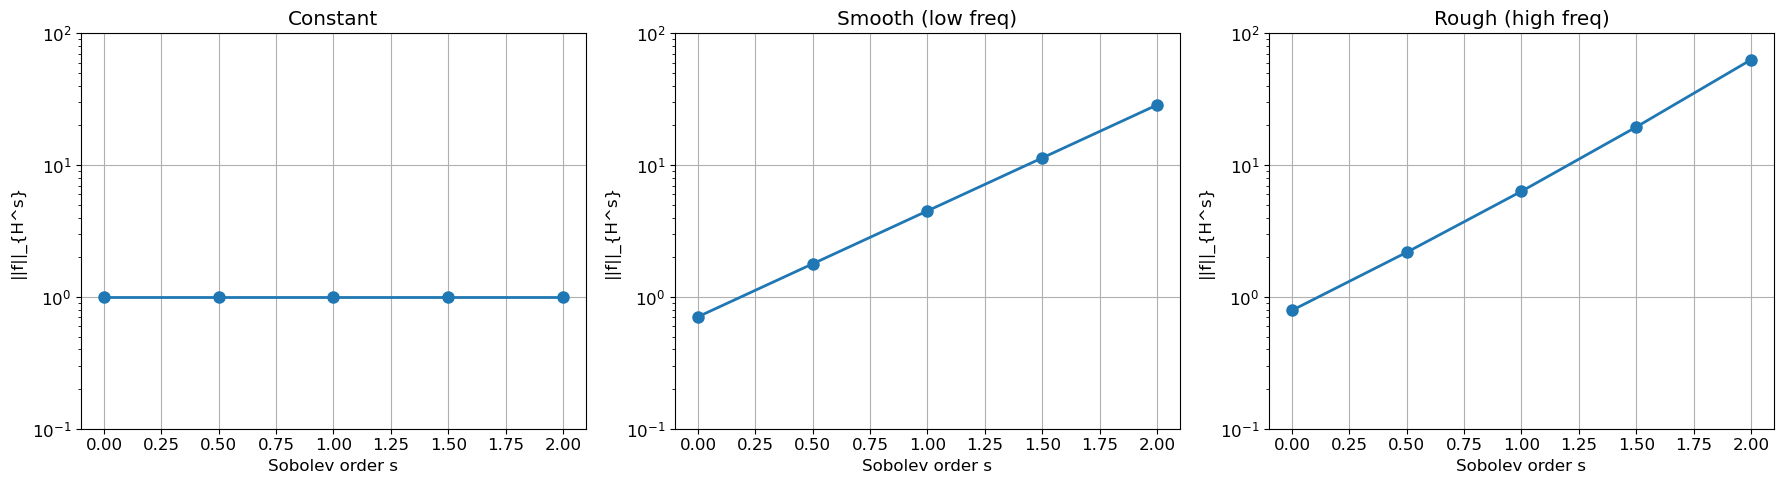

Observations:
- Constant function: norm stays relatively stable (low frequencies dominant).
- High frequency functions: norm grows rapidly with Sobolev order.
- This reflects the penalty on derivatives in H^s spaces.


In [10]:
print("=== Sobolev Norm Scaling with Order ===")

# Create spaces with different orders
orders = [0.0, 0.5, 1.0, 1.5, 2.0]
scaling_domain = IntervalDomain(0, 1)
scaling_bc = BoundaryConditions('periodic')
spaces = [Sobolev(6, scaling_domain, order, basis_type='fourier', boundary_conditions=scaling_bc) for order in orders]

# Test different functions
test_functions = [
    (const_func, 'Constant'),
    (smooth_func, 'Smooth (low freq)'),
    (rough_func, 'Rough (high freq)')
]

# Compute norms for each function and order
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (func, name) in enumerate(test_functions):
    norms = []
    for space in spaces:
        # Create function in the current space
        func_in_space = Function(space, evaluate_callable=func.evaluate_callable, name=func.name)
        norm = np.sqrt(space.inner_product(func_in_space, func_in_space))
        norms.append(norm)

    axes[idx].plot(orders, norms, 'o-', linewidth=2, markersize=8)
    axes[idx].set_xlabel('Sobolev order s')
    axes[idx].set_ylabel('||f||_{H^s}')
    axes[idx].set_title(f'{name}')
    axes[idx].grid(True)
    axes[idx].set_yscale('log')
    axes[idx].set_ylim(1e-1, 1e2)

plt.tight_layout()
plt.show()

print("Observations:")
print("- Constant function: norm stays relatively stable (low frequencies dominant).")
print("- High frequency functions: norm grows rapidly with Sobolev order.")
print("- This reflects the penalty on derivatives in H^s spaces.")

## 10. Coefficient Representation

Understanding how functions are represented as coefficients in the basis.

=== Coefficient Representation ===


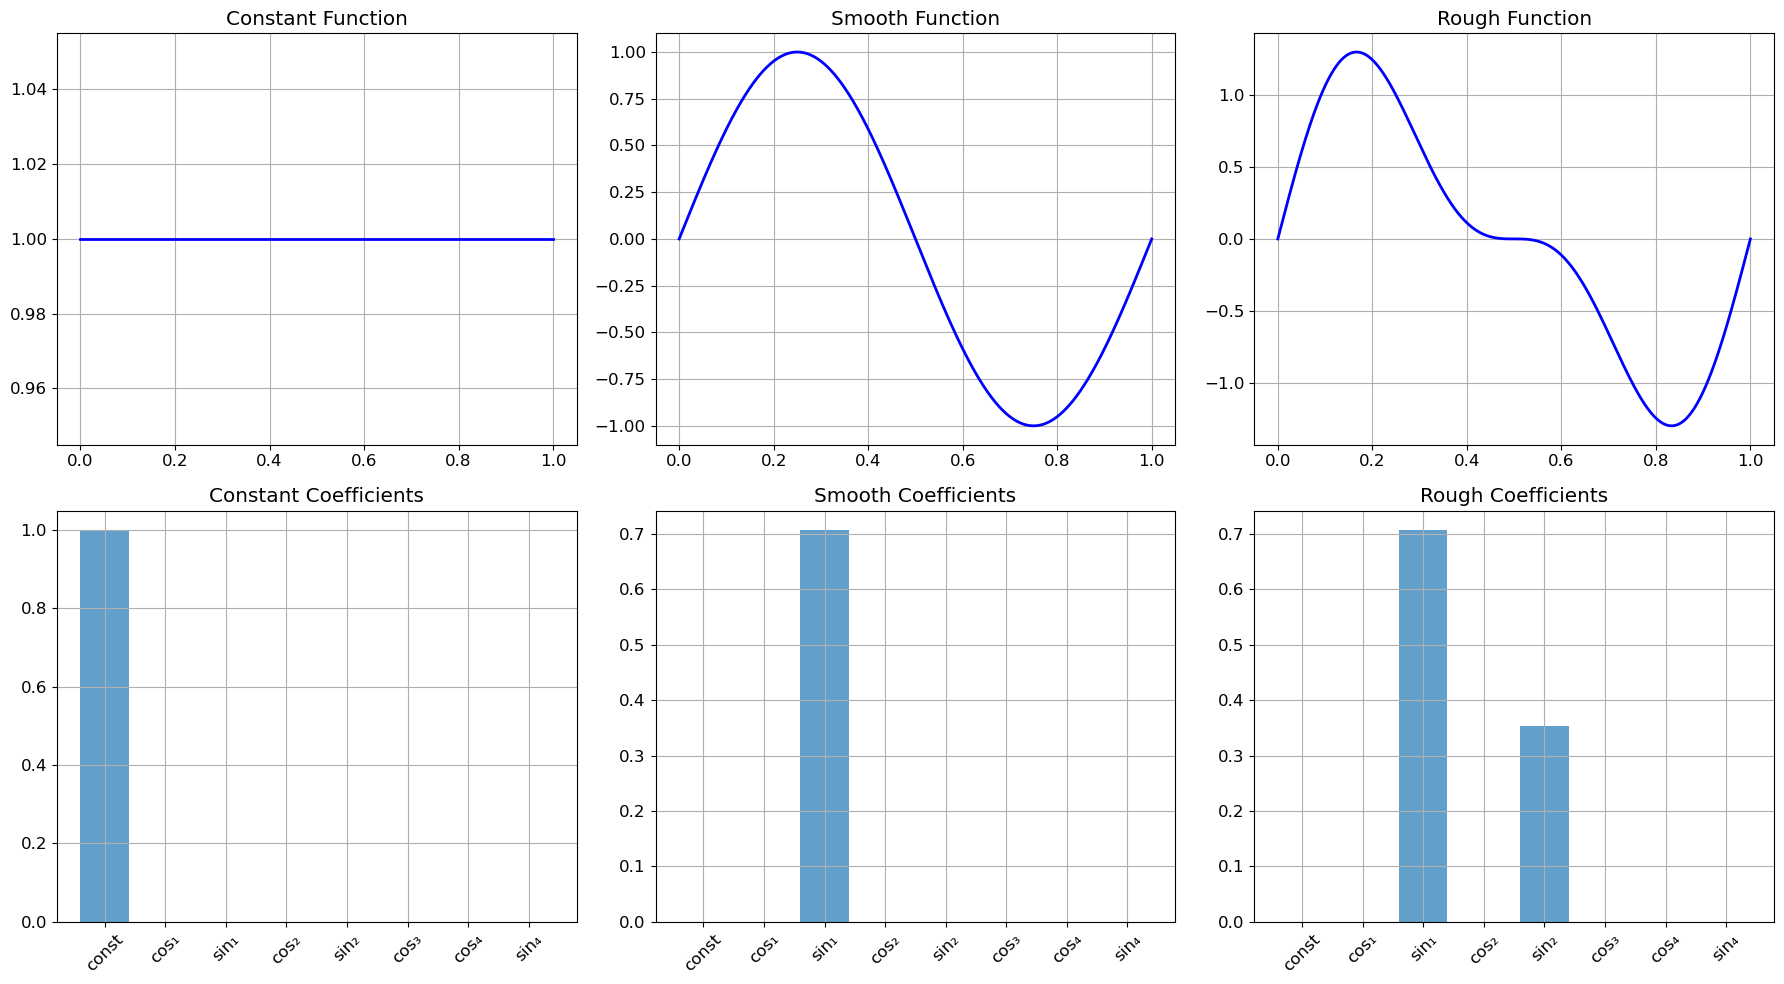


Reconstruction test (coefficient-based):
Constant: max coefficient error = 0.00e+00
  Constant: function evaluation error at x=0.5 = 0.00e+00
Smooth: max coefficient error = 5.55e-17
  Smooth: function evaluation error at x=0.5 = 1.64e-16
Rough: max coefficient error = 1.11e-16
  Rough: function evaluation error at x=0.5 = 4.22e-17


In [11]:
print("=== Coefficient Representation ===")

# Analyze coefficient representation of our test functions
functions = [(const_func, 'Constant'), (smooth_func, 'Smooth'), (rough_func, 'Rough')]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (func, name) in enumerate(functions):
    # Get coefficients
    coeffs = h1.to_components(func)

    # Plot function
    x = np.linspace(0, 1, 1000)
    axes[0, idx].plot(x, func.evaluate(x), 'b-', linewidth=2)
    axes[0, idx].set_title(f'{name} Function')
    axes[0, idx].grid(True)

    # Plot coefficients
    basis_names = ['const', 'cos₁', 'sin₁', 'cos₂', 'sin₂', 'cos₃', 'cos₄', 'sin₄'][:len(coeffs)]
    axes[1, idx].bar(range(len(coeffs)), coeffs, alpha=0.7)
    axes[1, idx].set_xticks(range(len(coeffs)))
    axes[1, idx].set_xticklabels(basis_names, rotation=45)
    axes[1, idx].set_title(f'{name} Coefficients')
    axes[1, idx].grid(True)

plt.tight_layout()
plt.show()

# Test reconstruction by comparing coefficients directly
print("\nReconstruction test (coefficient-based):")
for func, name in functions:
    original_coeffs = h1.to_components(func)
    reconstructed = h1.from_components(original_coeffs)
    reconstructed_coeffs = h1.to_components(reconstructed)

    max_coeff_error = np.max(np.abs(original_coeffs - reconstructed_coeffs))
    print(f"{name}: max coefficient error = {max_coeff_error:.2e}")

    # Test a simple evaluation at x=0.5 for sanity check
    try:
        orig_val = func.evaluate(0.5)
        recon_val = reconstructed.evaluate(0.5)
        eval_error = abs(orig_val - recon_val)
        print(f"  {name}: function evaluation error at x=0.5 = {eval_error:.2e}")
    except Exception as e:
        print(f"  {name}: evaluation test skipped due to error: {type(e).__name__}")